In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/name_mapping_validation_data.csv
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/survival_evaluation.csv
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_flair.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t2.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t1ce.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t1.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_Br

In [2]:
# Install and update required packages
!pip install nilearn
!pip install git+https://github.com/miykael/gif_your_nifti  # nifti to gif 
!pip install tensorflow==2.16.1  # Matching TensorFlow version for compatibility

# Standard libraries
import os
import cv2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageOps  
from skimage import data
from skimage.util import montage
from skimage.transform import rotate, resize

# Neural imaging libraries
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
import gif_your_nifti.core as gif2nif

# Machine learning libraries
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

# Make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

  Cloning https://github.com/miykael/gif_your_nifti to /tmp/pip-req-build-_tlj_cxt
  Running command git clone --filter=blob:none --quiet https://github.com/miykael/gif_your_nifti /tmp/pip-req-build-_tlj_cxt
  Resolved https://github.com/miykael/gif_your_nifti to commit 55c09c42921f4871cf43f63a303ab420a92a4f03
  Preparing metadata (setup.py) ... done
  Created wheel for gif_your_nifti: filename=gif_your_nifti-0.2.2-py3-none-any.whl size=6633 sha256=d2ee8c196229ec9a5e637066403ddb07b52bf4622baf787c165c34b22170d6d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-namk8tk3/wheels/3a/c2/0b/c08f2425925519bb014e107d2919dadc2556ec5e7c205e4472
Successfully built gif_your_nifti


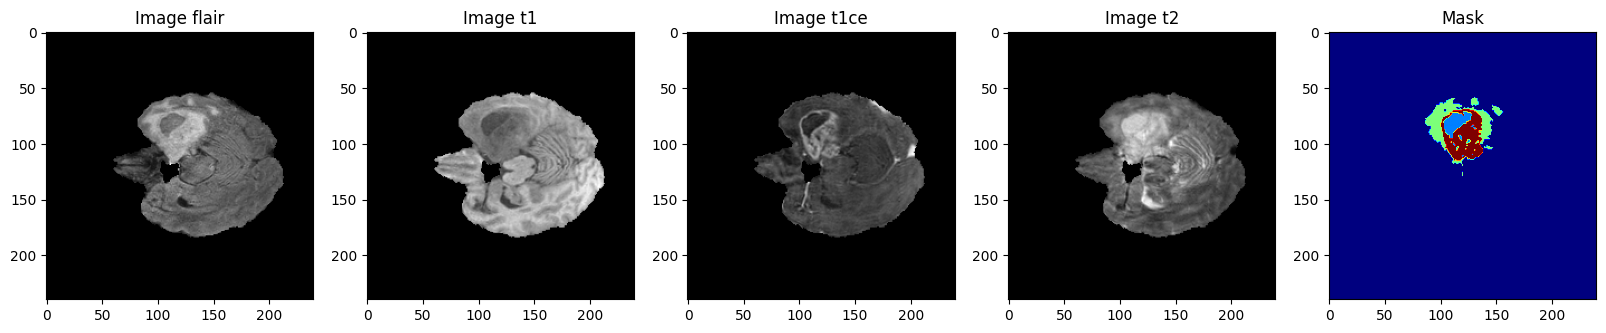

In [3]:
import os
import nibabel as nib
import matplotlib.pyplot as plt

# Dataset paths
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

# Load images and mask
test_image_flair = nib.load(os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')).get_fdata()
test_image_t1 = nib.load(os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_001/BraTS20_Training_001_t1.nii')).get_fdata()
test_image_t1ce = nib.load(os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii')).get_fdata()
test_image_t2 = nib.load(os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_001/BraTS20_Training_001_t2.nii')).get_fdata()
test_mask = nib.load(os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')).get_fdata()

# Visualization
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 10))
slice_w = 25

# Plot each image type
ax1.imshow(test_image_flair[:, :, test_image_flair.shape[2]//2 - slice_w], cmap='gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:, :, test_image_t1.shape[2]//2 - slice_w], cmap='gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:, :, test_image_t1ce.shape[2]//2 - slice_w], cmap='gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:, :, test_image_t2.shape[2]//2 - slice_w], cmap='gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:, :, test_mask.shape[2]//2 - slice_w], cmap='jet')  # Using a different colormap for segmentation mask
ax5.set_title('Mask')
plt.show()

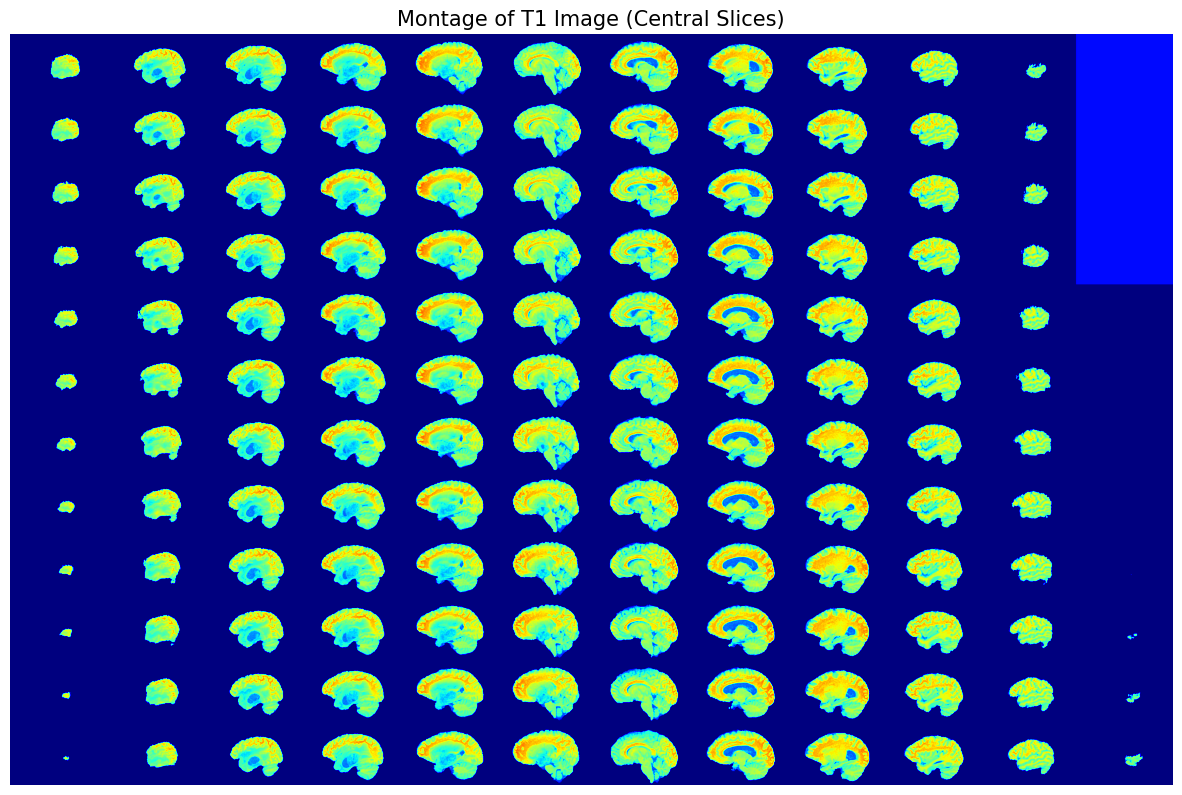

In [6]:
from skimage.util import montage
from skimage.transform import rotate

# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize=(15, 15))
ax1.imshow(rotate(montage(test_image_t1[50:-50, :, :]), 90, resize=True), cmap='jet')
ax1.set_title('Montage of T1 Image (Central Slices)', fontsize=15)
ax1.axis('off')  # Hide axes for a cleaner visualization
plt.show()

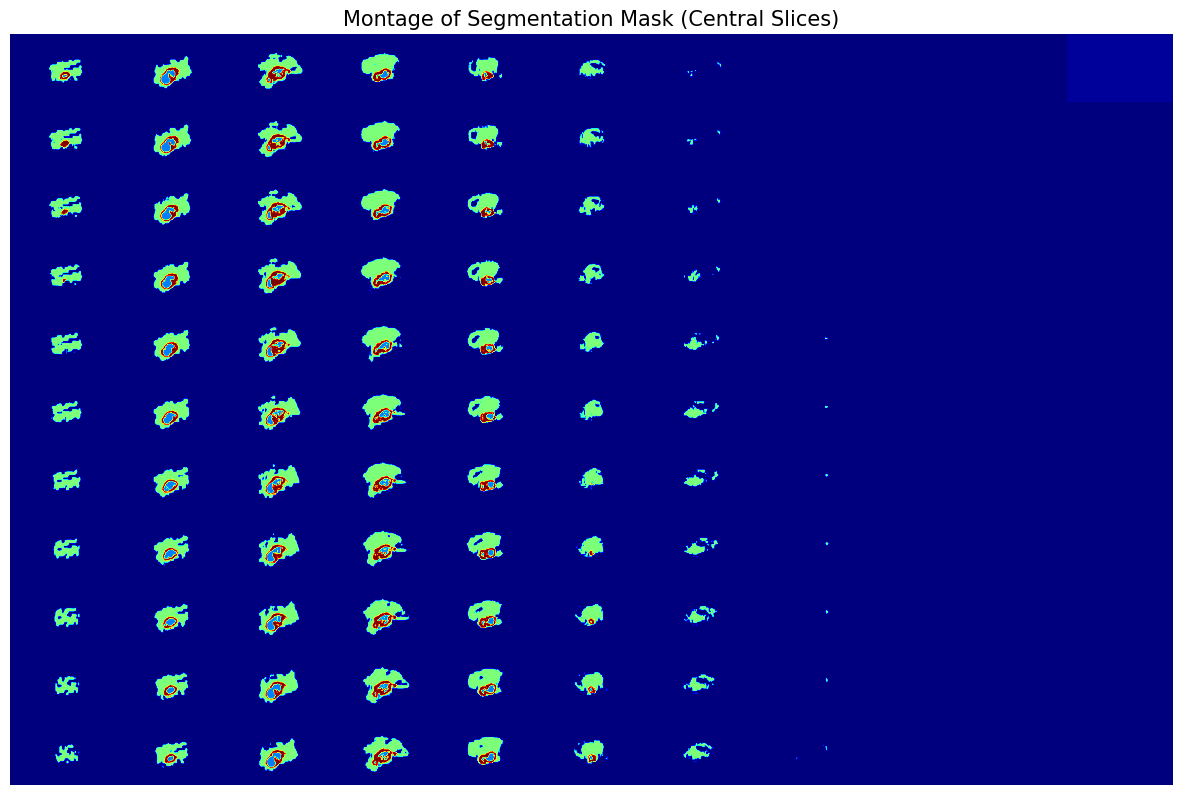

In [7]:
from skimage.util import montage
from skimage.transform import rotate

# Skip 60:-60 slices to focus on central part
fig, ax1 = plt.subplots(1, 1, figsize=(15, 15))
ax1.imshow(rotate(montage(test_mask[60:-60, :, :]), 90, resize=True), cmap='jet')  # Using 'jet' colormap for better contrast
ax1.set_title('Montage of Segmentation Mask (Central Slices)', fontsize=15)
ax1.axis('off')  # Hide axes for a cleaner visualization
plt.show()

In [8]:
import shutil
import os
from gif_your_nifti.core import write_gif_normal

# Define source and destination paths
src_path = os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
dest_path = './test_gif_BraTS20_Training_001_flair.nii'

# Copy file if it does not already exist in the destination
if not os.path.exists(dest_path):
    shutil.copy2(src_path, dest_path)

# Convert the NIfTI file to GIF
write_gif_normal(dest_path)

/tmp/ipykernel_30/2916986447.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


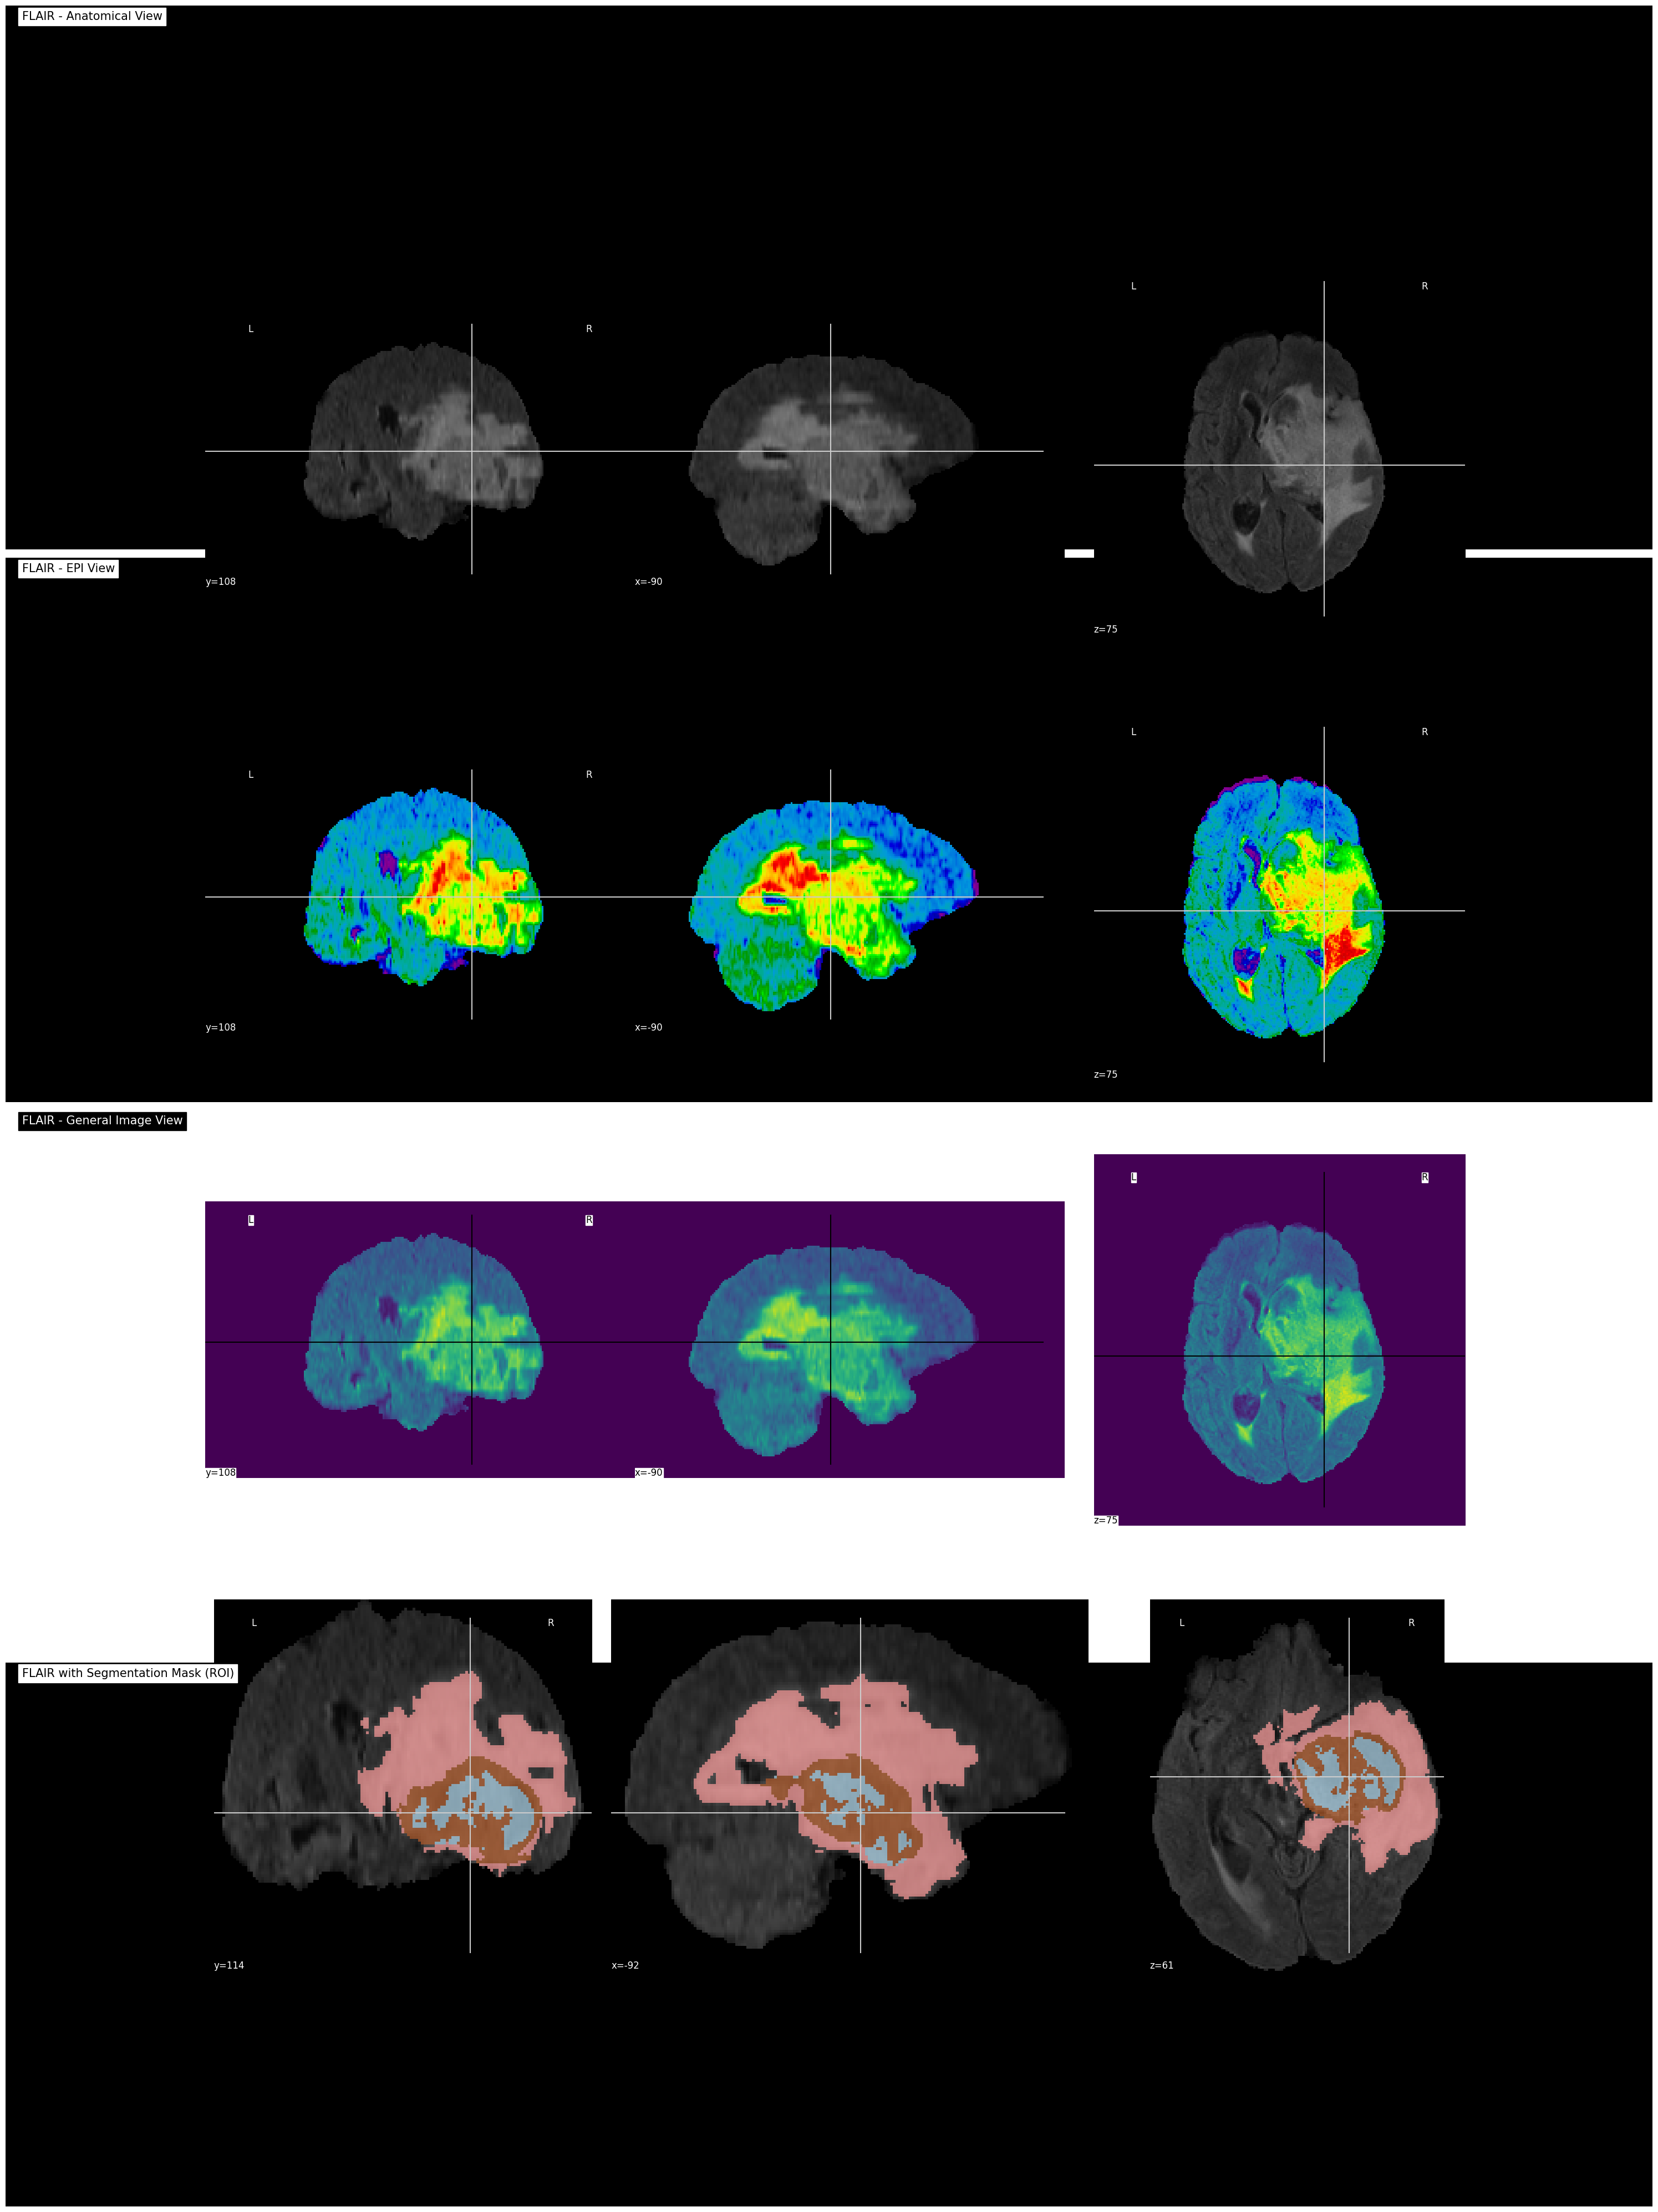

In [9]:
import nilearn.plotting as nlplt
from nilearn import image as nlimg
import matplotlib.pyplot as plt

# Load images
niimg = nlimg.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nlimg.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

# Plot images in a 4-row layout
fig, axes = plt.subplots(nrows=4, figsize=(30, 40))

nlplt.plot_anat(niimg, title='FLAIR - Anatomical View', axes=axes[0])
nlplt.plot_epi(niimg, title='FLAIR - EPI View', axes=axes[1])
nlplt.plot_img(niimg, title='FLAIR - General Image View', axes=axes[2])
nlplt.plot_roi(nimask, title='FLAIR with Segmentation Mask (ROI)', bg_img=niimg, axes=axes[3], cmap='Paired')

plt.tight_layout()
plt.show()

In [11]:
import keras.backend as K

# Overall Dice coefficient across all classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice_score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice_score / class_num  # Averaging across all classes

# Per-class Dice coefficients
def dice_coef_class(y_true, y_pred, class_idx, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, class_idx] * y_pred[:, :, :, class_idx]))
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, class_idx])) + K.sum(K.square(y_pred[:, :, :, class_idx])) + epsilon)

def dice_coef_necrotic(y_true, y_pred):
    return dice_coef_class(y_true, y_pred, class_idx=1)

def dice_coef_edema(y_true, y_pred):
    return dice_coef_class(y_true, y_pred, class_idx=2)

def dice_coef_enhancing(y_true, y_pred):
    return dice_coef_class(y_true, y_pred, class_idx=3)

# Precision metric
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

# Sensitivity (Recall) metric
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Specificity metric
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [12]:
import cv2
import numpy as np

# Function to resize images and masks
def resize_image(img, img_size=128):
    return cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_LINEAR)

def resize_mask(mask, img_size=128):
    return cv2.resize(mask, (img_size, img_size), interpolation=cv2.INTER_NEAREST)

IMG_SIZE=128



In [13]:
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Dropout, concatenate
from tensorflow.keras.models import Model
import tensorflow as tf

# Define the U-Net model
def build_unet(inputs, ker_init='he_normal', dropout=0.2):
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
    
    pool = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    conv = Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(pool)
    conv = Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv)
    
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv)
    conv2 = Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
    
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    conv3 = Conv3D(256, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv3D(256, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
    
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    # Up-sampling and concatenation
    up7 = Conv3D(256, (2, 2, 2), activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(drop5))
    merge7 = concatenate([conv3, up7])
    conv7 = Conv3D(256, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = Conv3D(256, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv7)

    up8 = Conv3D(128, (2, 2, 2), activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(conv7))
    merge8 = concatenate([conv2, up8])
    conv8 = Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv8)

    up9 = Conv3D(64, (2, 2, 2), activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(conv8))
    merge9 = concatenate([conv, up9])
    conv9 = Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
    conv9 = Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv9)
    
    up = Conv3D(32, (2, 2, 2), activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(conv9))
    merge = concatenate([conv1, up])
    conv = Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(merge)
    conv = Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv)
    
    conv10 = Conv3D(4, (1, 1, 1), activation='softmax')(conv)
    
    return Model(inputs=inputs, outputs=conv10)

# Input layer
input_layer = Input((IMG_SIZE, IMG_SIZE, IMG_SIZE, 3))

# Build and compile the model
model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(
    loss="categorical_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    metrics=[
        'accuracy', tf.keras.metrics.MeanIoU(num_classes=4), 
        dice_coef, precision, sensitivity, specificity, 
        dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing
    ]
)

In [24]:
!pip install pydot
!apt-get install graphviz -y  # For systems that use apt-get (like Colab or some Linux environments)


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-liberation2 libabsl20220623 libann0 libavif15 libcdt5 libcgraph6
  libgav1-1 libgd3 libgts-0.7-5 libgts-bin libgvc6 libgvpr2 liblab-gamut1
  libpathplan4 libxaw7 libxmu6 libxpm4 libyuv0
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fonts-liberation2 graphviz libabsl20220623 libann0 libavif15 libcdt5
  libcgraph6 libgav1-1 libgd3 libgts-0.7-5 libgts-bin libgvc6 libgvpr2
  liblab-gamut1 libpathplan4 libxaw7 libxmu6 libxpm4 libyuv0
0 upgraded, 19 newly installed, 0 to remove and 0 not upgraded.
Need to get 4953 kB of archives.
After this operation, 18.7 MB of additional disk space will be used.
Get:1 http://deb.debian.org/debian bookworm/main amd64 fonts-liberation2 

In [27]:
from tensorflow.keras.utils import plot_model

plot_model(model, 
           to_file="unet_model_architecture.png",  # Saves the plot to file
           show_shapes=True,
           show_dtype=False,
           show_layer_names=True, 
           rankdir='TB', 
           expand_nested=False, 
           dpi=100)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [28]:
!pip install pydot graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


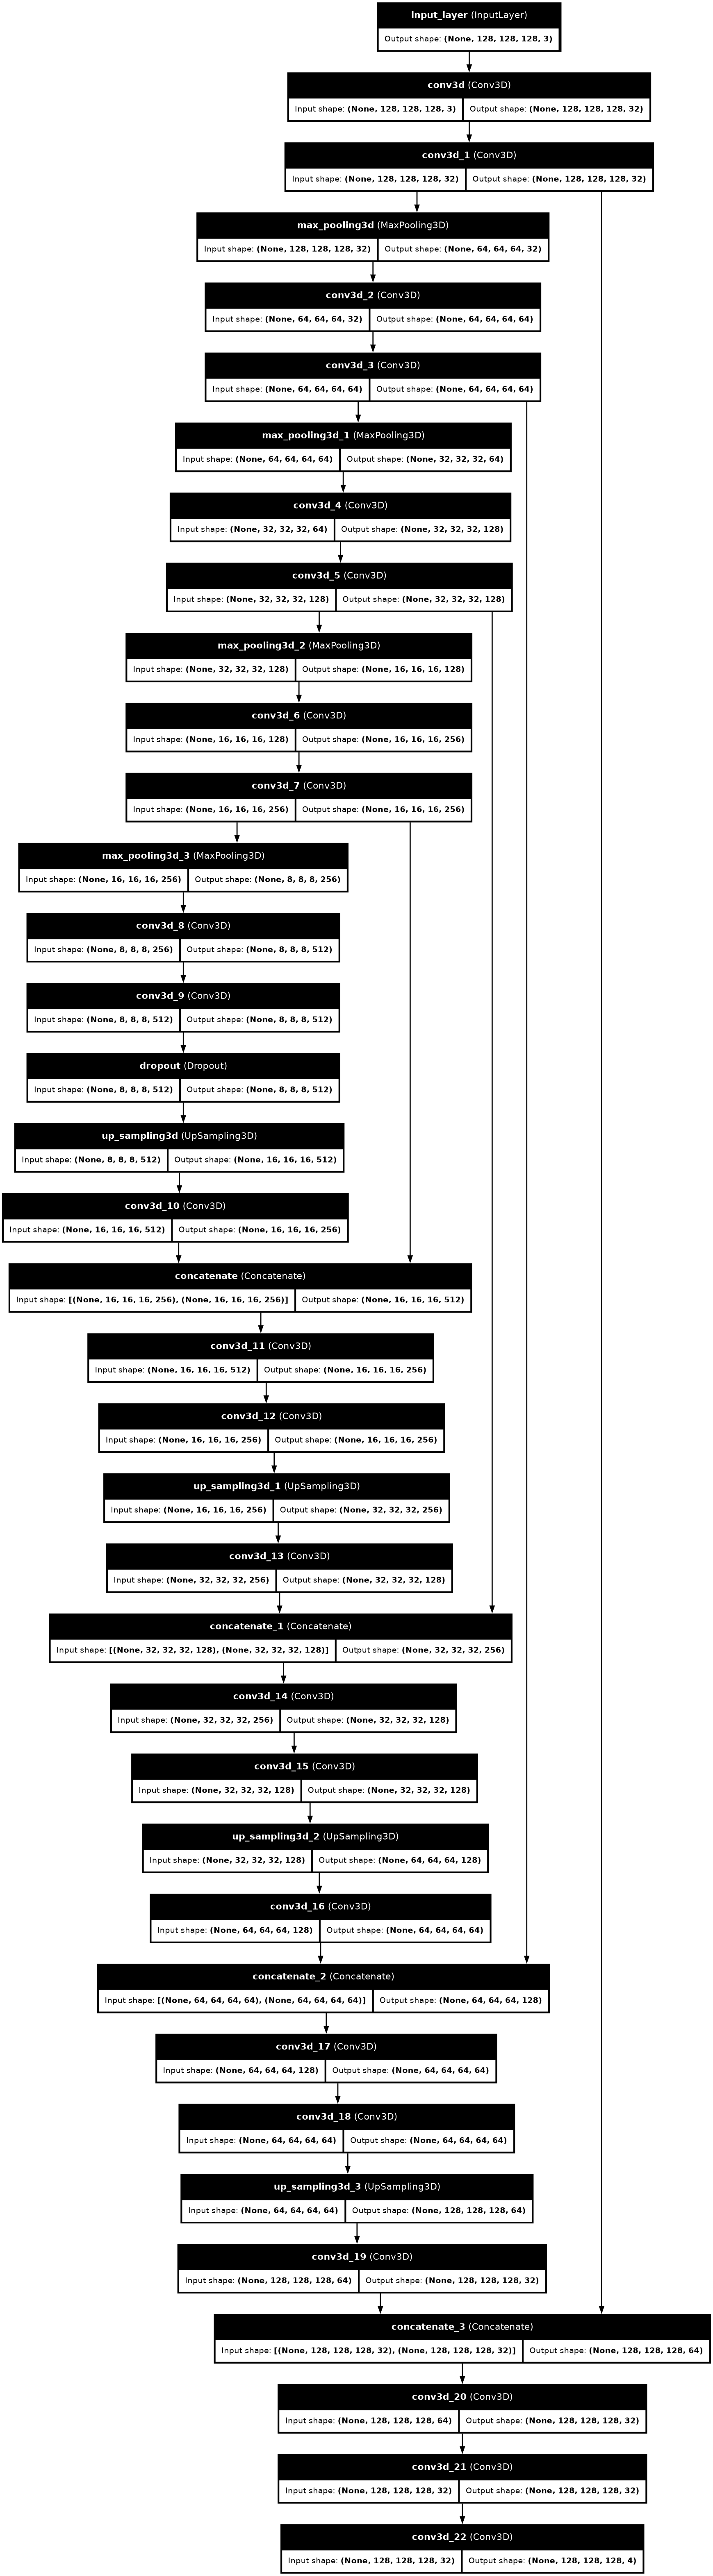

In [14]:
from tensorflow.keras.utils import plot_model

plot_model(model, 
           to_file="unet_model_architecture.png",  # Saves the plot to file
           show_shapes=True,
           show_dtype=False,
           show_layer_names=True, 
           rankdir='TB', 
           expand_nested=False, 
           dpi=100)

In [30]:
!pip install pydot
!pip install graphviz


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [31]:
from tensorflow.keras.utils import plot_model

plot_model(model, 
           to_file="unet_model_architecture.png",  # Saves the plot to file
           show_shapes=True,
           show_dtype=False,
           show_layer_names=True, 
           rankdir='TB', 
           expand_nested=False, 
           dpi=100)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [32]:
!which dot

/usr/bin/dot


In [33]:
import os
os.environ["PATH"] += os.pathsep + '/usr/bin'

In [34]:
from tensorflow.keras.utils import plot_model

plot_model(model, 
           to_file="unet_model_architecture.png",  # Saves the plot to file
           show_shapes=True,
           show_dtype=False,
           show_layer_names=True, 
           rankdir='TB', 
           expand_nested=False, 
           dpi=100)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [35]:
!pip uninstall -y pydot pydot-ng
!pip install pydot pydot-ng graphviz

Found existing installation: pydot 3.0.2
Uninstalling pydot-3.0.2:
  Successfully uninstalled pydot-3.0.2
  Using cached pydot-3.0.2-py3-none-any.whl (35 kB)

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [36]:
 pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.2 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Note: you may need to restart the kernel to use updated packages.


In [42]:
import os
os.environ["PATH"] += os.pathsep + '/usr/bin'

In [15]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 128, 128,  │      2,624 │ input_layer[0][0] │
│                     │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 128, 128,  │     27,680 │ conv3d[0][0]      │
│                     │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 64, 64,    │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 64, 64,    │     55,360 │ max_pooling3d[0]… │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 64, 64,    │    110,656 │ conv3d_2[0][0]    │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 32, 32,    │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 32, 32,    │    221,312 │ max_pooling3d_1[… │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 32, 32,    │    442,496 │ conv3d_4[0][0]    │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 16, 16,    │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 16, 16,    │    884,992 │ max_pooling3d_2[… │
│                     │ 16, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 16, 16,    │  1,769,728 │ conv3d_6[0][0]    │
│                     │ 16, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_3     │ (None, 8, 8, 8,   │          0 │ conv3d_7[0][0]    │
│ (MaxPooling3D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_8 (Conv3D)   │ (None, 8, 8, 8,   │  3,539,456 │ max_pooling3d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_9 (Conv3D)   │ (None, 8, 8, 8,   │  7,078,400 │ conv3d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8, 8, 8,   │          0 │ conv3d_9[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling3d       │ (None, 16, 16,    │          0 │ dropout[0][0]   

 Total params: 22,577,156 (86.13 MB)

 Trainable params: 22,577,156 (86.13 MB)

 Non-trainable params: 0 (0.00 B)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 18.2 MB/s eta 0:00:00a 0:00:01


/opt/conda/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


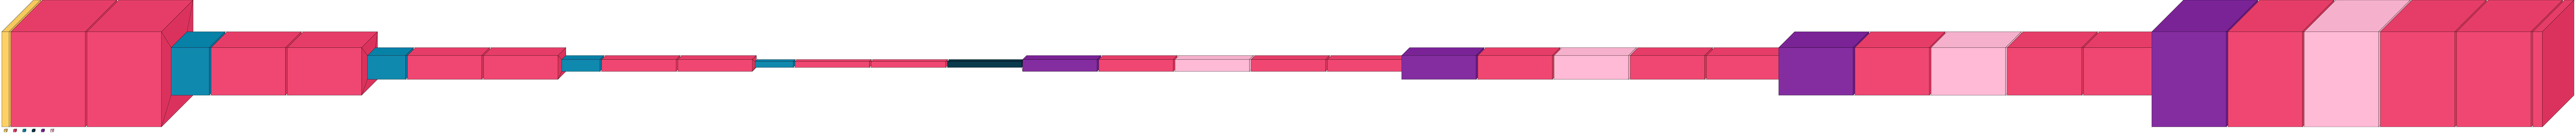

In [16]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model, to_file='model.png', legend=True)

In [17]:
import os
from sklearn.model_selection import train_test_split

# List of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# Remove specific directory with misformatted filename
train_and_val_directories.remove(os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_355'))

# Function to extract IDs from paths
def pathListIntoIds(dirList):
    return [os.path.basename(path) for path in dirList]

# Extracting study IDs
train_and_test_ids = pathListIntoIds(train_and_val_directories)

# Split into training, validation, and testing sets with reproducibility
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2, random_state=42)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15, random_state=42)

# Check splits
print(f"Training IDs: {len(train_ids)}, Validation IDs: {len(val_ids)}, Testing IDs: {len(test_ids)}")

Training IDs: 249, Validation IDs: 74, Testing IDs: 45


In [20]:
import os
import numpy as np
import cv2
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.utils import Sequence

# Parameters for volume handling
VOLUME_SLICES = 60  # Number of slices to process per volume
VOLUME_START_AT = 20  # Starting slice index (for center slices)

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, Y = self.__data_generation(Batch_ids)
        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))  # Original mask size

        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            # Load flair and t1ce images
            flair = nib.load(os.path.join(case_path, f'{i}_flair.nii')).get_fdata()
            t1ce = nib.load(os.path.join(case_path, f'{i}_t1ce.nii')).get_fdata()
            seg = nib.load(os.path.join(case_path, f'{i}_seg.nii')).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], self.dim)
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], self.dim)
                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

        # Update mask values and one-hot encode
        y[y == 4] = 3  # Convert label 4 to 3 for consistency
        mask = tf.one_hot(y, depth=4)
        Y = tf.image.resize(mask, self.dim)  # Resize to target dimensions

        return X / np.max(X), Y  # Normalize images

# Create data generators
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

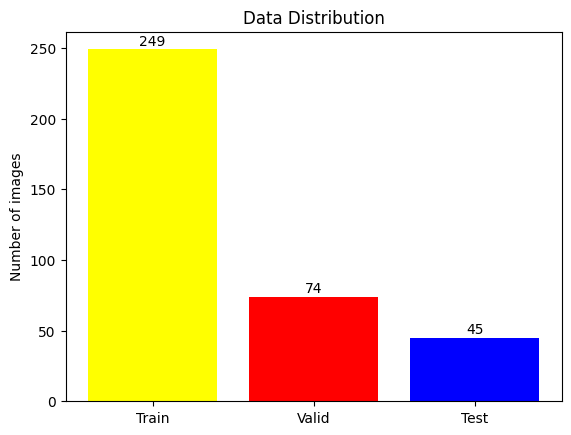

In [21]:
import matplotlib.pyplot as plt

def showDataLayout():
    # Number of images in each set
    counts = [len(train_ids), len(val_ids), len(test_ids)]
    labels = ["Train", "Valid", "Test"]
    colors = ['yellow', 'red', 'blue']
    
    plt.bar(labels, counts, color=colors, align='center')
    plt.ylabel('Number of images')
    plt.title('Data Distribution')

    # Display the count on top of each bar
    for i, count in enumerate(counts):
        plt.text(i, count + 1, str(count), ha='center', va='bottom')

    plt.show()

# Show data distribution
showDataLayout()

In [22]:
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# CSV Logger to log training history
csv_logger = CSVLogger('training.log', separator=',', append=False)

# Callbacks
callbacks = [
    # Early stopping to prevent overfitting (recommended if validation performance stops improving)
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True),

    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1),

    # Model checkpoint to save the best model weights based on validation loss
    ModelCheckpoint(filepath='best_model.weights.h5', monitor='val_loss', verbose=1, 
                    save_best_only=True, save_weights_only=True, mode='min'),

    # CSV logger to save training logs
    csv_logger
]

In [27]:
import os
print(os.listdir())

['test_gif_BraTS20_Training_001_flair.nii', 'test_gif_BraTS20_Training_001_flair.gif', 'training.log', 'unet_model_architecture.png', '.virtual_documents', 'model.png']


In [30]:
input_layer = Input((IMG_SIZE, IMG_SIZE, IMG_SIZE, 2))  # Change 3 to 2 channels

In [32]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K

IMG_SIZE = 128  # Define the size for resizing the images

# Define the U-Net model with 2 channels
def build_unet(inputs, ker_init='he_normal', dropout=0.2):
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
    
    pool = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    conv = Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(pool)
    conv = Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv)
    
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv)
    conv2 = Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
    
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    conv3 = Conv3D(256, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv3D(256, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
    
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    # Up-sampling and concatenation
    up7 = Conv3D(256, (2, 2, 2), activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(drop5))
    merge7 = concatenate([conv3, up7])
    conv7 = Conv3D(256, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = Conv3D(256, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv7)

    up8 = Conv3D(128, (2, 2, 2), activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(conv7))
    merge8 = concatenate([conv2, up8])
    conv8 = Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv8)

    up9 = Conv3D(64, (2, 2, 2), activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(conv8))
    merge9 = concatenate([conv, up9])
    conv9 = Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
    conv9 = Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv9)
    
    up = Conv3D(32, (2, 2, 2), activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(conv9))
    merge = concatenate([conv1, up])
    conv = Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(merge)
    conv = Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv)
    
    conv10 = Conv3D(4, (1, 1, 1), activation='softmax')(conv)
    
    return Model(inputs=inputs, outputs=conv10)

# Input layer with 2 channels
input_layer = Input((IMG_SIZE, IMG_SIZE, IMG_SIZE, 2))
model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(
    loss="categorical_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4)]
)

In [33]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, Y = self.__data_generation(Batch_ids)
        return X, Y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 2))  # 2 channels
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))  # Original mask size

        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            flair = nib.load(os.path.join(case_path, f'{i}_flair.nii')).get_fdata()
            t1ce = nib.load(os.path.join(case_path, f'{i}_t1ce.nii')).get_fdata()
            seg = nib.load(os.path.join(case_path, f'{i}_seg.nii')).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], self.dim)
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], self.dim)
                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

        y[y == 4] = 3  # Convert label 4 to 3 for consistency
        mask = tf.one_hot(y, depth=4)
        Y = tf.image.resize(mask, self.dim)

        return X / np.max(X), Y  # Normalize images

In [35]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate
from tensorflow.keras.models import Model

def build_unet_2d(inputs, ker_init='he_normal', dropout=0.2):
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(pool)
    conv = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, (2, 2), activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(drop5))
    merge7 = concatenate([conv3, up7])
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv7)

    up8 = Conv2D(128, (2, 2), activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8])
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv8)

    up9 = Conv2D(64, (2, 2), activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv, up9])
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv9)
    
    up = Conv2D(32, (2, 2), activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv9))
    merge = concatenate([conv1, up])
    conv = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(merge)
    conv = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv)
    
    conv10 = Conv2D(4, (1, 1), activation='softmax')(conv)
    
    return Model(inputs=inputs, outputs=conv10)

# Define input layer for 2D model
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
model = build_unet_2d(input_layer, 'he_normal', 0.2)

model.compile(
    loss="categorical_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4)]
)

In [36]:
# Define callbacks
csv_logger = CSVLogger('training.log', separator=',', append=False)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1),
    ModelCheckpoint(filepath='best_model.weights.h5', monitor='val_loss', verbose=1, 
                    save_best_only=True, save_weights_only=True, mode='min'),
    csv_logger
]

# Training parameters
batch_size = 1  # Set as required

# Create data generators
training_generator = DataGenerator(train_ids, batch_size=batch_size)
valid_generator = DataGenerator(val_ids, batch_size=batch_size)

# Train the model
K.clear_session()
history = model.fit(
    training_generator,
    epochs=35,
    steps_per_epoch=len(train_ids) // batch_size,
    callbacks=callbacks,
    validation_data=valid_generator
)

# Save the full model
model.save("model_x1_1.h5")

Epoch 1/35


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731505294.091646     121 service.cc:145] XLA service 0x7d1cf8003570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731505294.091717     121 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/249 ━━━━━━━━━━━━━━━━━━━━ 2:05:40 30s/step - accuracy: 0.6069 - loss: 1.2909 - mean_io_u: 0.3754

I0000 00:00:1731505313.940972     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9745 - loss: 0.1932 - mean_io_u: 0.4592
Epoch 1: val_loss improved from inf to 0.09149, saving model to best_model.weights.h5
249/249 ━━━━━━━━━━━━━━━━━━━━ 196s 669ms/step - accuracy: 0.9745 - loss: 0.1928 - mean_io_u: 0.4594 - val_accuracy: 0.9865 - val_loss: 0.0915 - val_mean_io_u: 0.4999 - learning_rate: 1.0000e-04
Epoch 2/35


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 0.09149
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u: 0.0000e+00 - val_accuracy: 0.9865 - val_loss: 0.0915 - val_mean_io_u: 0.4999 - learning_rate: 1.0000e-04
Epoch 3/35
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9849 - loss: 0.0694 - mean_io_u: 0.5255
Epoch 3: val_loss improved from 0.09149 to 0.05279, saving model to best_model.weights.h5
249/249 ━━━━━━━━━━━━━━━━━━━━ 55s 215ms/step - accuracy: 0.9849 - loss: 0.0694 - mean_io_u: 0.5254 - val_accuracy: 0.9865 - val_loss: 0.0528 - val_mean_io_u: 0.5000 - learning_rate: 1.0000e-04
Epoch 4/35

Epoch 4: val_loss improved from 0.05279 to 0.05279, saving model to best_model.weights.h5
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u: 0.0000e+00 - val_accuracy: 0.9865 - val_loss: 0.0528 - val_mean_io_u: 0.5000 - learning_rate: 1.0000e-04
Epoch 5/35
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step 

In [37]:
model.save("final_model.h5")

In [39]:
from tensorflow.keras.models import load_model

# Load the model architecture and compile it
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))  # Adjust to your input shape
model = build_unet_2d(input_layer, 'he_normal', 0.2)
model.compile(
    loss="categorical_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4)]
)

# Load the best weights
model.load_weights("best_model.weights.h5")

# Evaluate the model on the test set
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_generator, verbose=1)

# Display the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Mean IoU: {test_mean_iou:.4f}")

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


45/45 ━━━━━━━━━━━━━━━━━━━━ 27s 568ms/step - accuracy: 0.9912 - loss: 0.0263 - mean_io_u: 0.6889
Test Loss: 0.0224
Test Accuracy: 0.9927
Test Mean IoU: 0.5708


In [42]:
import numpy as np
from sklearn.metrics import classification_report, jaccard_score
import pandas as pd

# Generate predictions for the entire test set
y_pred = []
y_true = []

for X, y in test_generator:
    preds = model.predict(X)
    y_pred.extend(np.argmax(preds, axis=-1).flatten())  # Flatten predictions
    y_true.extend(np.argmax(y, axis=-1).flatten())      # Flatten true labels
    if len(y_true) >= len(y_pred):  # Stop if we've matched lengths
        break

# Convert to numpy arrays
y_true = np.array(y_true[:len(y_pred)])
y_pred_flat = np.array(y_pred)

# Calculate classification metrics
report = classification_report(y_true, y_pred_flat, output_dict=True)
iou_scores = jaccard_score(y_true, y_pred_flat, average=None)  # Per class IoU

# Create DataFrame for metrics
metrics_df = pd.DataFrame(report).transpose()

# Add IoU scores, aligning them with class rows and leaving NaN for summary rows
iou_series = pd.Series(iou_scores, index=metrics_df.index[:len(iou_scores)])
metrics_df["IoU"] = iou_series

# Display results as a table
metrics_df_display = metrics_df[['precision', 'recall', 'f1-score', 'IoU', 'support']]
print("Full Evaluation Results:")
metrics_df_display

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Full Evaluation Results:


precision    recall  f1-score       IoU        support
0              0.999573  0.996438  0.998003  0.996014  981708.000000
1              0.000000  0.000000  0.000000  0.000000     485.000000
2              0.113353  0.590319  0.190186  0.105086     847.000000
accuracy       0.995596  0.995596  0.995596       NaN       0.995596
macro avg      0.370975  0.528919  0.396063       NaN  983040.000000
weighted avg   0.998316  0.995596  0.996814       NaN  983040.000000

In [44]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * y_true * K.pow((1 - y_pred), gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

In [47]:
class_weights = {0: 1.0, 1: 5.0, 2: 3.0}  # Example weights, adjust as needed

In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')
image_datagen = ImageDataGenerator(**data_gen_args)

In [51]:
def weighted_focal_loss(gamma=2., class_weights=[1.0, 5.0, 3.0, 1.0]):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = y_true * class_weights  # Apply class weights
        focal_weight = weight * K.pow((1 - y_pred), gamma)
        loss = focal_weight * cross_entropy
        return K.sum(loss, axis=-1)
    return focal_loss_fixed

# Use this as the loss function
loss_function = weighted_focal_loss(gamma=2., class_weights=[1.0, 5.0, 3.0, 1.0])

In [52]:
history = model.fit(
    training_generator,
    epochs=35,
    steps_per_epoch=len(train_ids) // batch_size,
    validation_data=valid_generator,
    callbacks=callbacks
)

# Save the model
model.save("model_with_improvements_no_class_weights.h5")

Epoch 1/35
249/249 ━━━━━━━━━━━━━━━━━━━━ 68s 226ms/step - accuracy: 0.9855 - dice_coef: 0.2399 - loss: 0.1803 - mean_io_u_1: 0.5300 - precision: 0.9932 - sensitivity: 0.9772 - specificity: 0.9976 - val_accuracy: 0.9897 - val_dice_coef: 0.2423 - val_loss: 0.1167 - val_mean_io_u_1: 0.5000 - val_precision: 0.9957 - val_sensitivity: 0.9838 - val_specificity: 0.9984 - learning_rate: 1.0000e-04
Epoch 2/35


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.0000e+00 - dice_coef: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u_1: 0.0000e+00 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 0.0000e+00 - val_accuracy: 0.9897 - val_dice_coef: 0.2423 - val_loss: 0.1167 - val_mean_io_u_1: 0.5000 - val_precision: 0.9957 - val_sensitivity: 0.9838 - val_specificity: 0.9984 - learning_rate: 1.0000e-04
Epoch 3/35
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9884 - dice_coef: 0.2399 - loss: 0.1407 - mean_io_u_1: 0.5085 - precision: 0.9942 - sensitivity: 0.9814 - specificity: 0.9979
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
249/249 ━━━━━━━━━━━━━━━━━━━━ 55s 219ms/step - accuracy: 0.9884 - dice_coef: 0.2399 - loss: 0.1407 - mean_io_u_1: 0.5085 - precision: 0.9942 - sensitivity: 0.9814 - specificity: 0.9979 - val_accuracy: 0.9881 - val_dice_coef: 0.2360 - val_loss: 0.1464 - val_mean_io_u_1: 0.5000 - val_precision: 0.9951 - val_sensitivity: 0.9

In [53]:
from sklearn.metrics import classification_report, jaccard_score
import pandas as pd
import numpy as np

# Evaluate the model on the test data
test_loss, test_accuracy, test_dice_coef, test_mean_iou, test_precision, test_sensitivity, test_specificity = model.evaluate(test_generator)

# Prepare a dictionary for test results
results = {
    "Metric": ["Loss", "Accuracy", "Dice Coefficient", "Mean IoU", "Precision", "Sensitivity", "Specificity"],
    "Score": [test_loss, test_accuracy, test_dice_coef, test_mean_iou, test_precision, test_sensitivity, test_specificity]
}

# Convert to DataFrame for a clear tabular view
results_df = pd.DataFrame(results)

# Display the results
print("Test Set Evaluation Results:")
print(results_df)


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 447ms/step - accuracy: 0.9923 - dice_coef: 0.2435 - loss: 0.0704 - mean_io_u_1: 0.5976 - precision: 0.9966 - sensitivity: 0.9871 - specificity: 0.9987
Test Set Evaluation Results:
             Metric     Score
0              Loss  0.061051
1          Accuracy  0.993606
2  Dice Coefficient  0.500000
3          Mean IoU  0.243882
4         Precision  0.997001
5       Sensitivity  0.989138
6       Specificity  0.998827


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


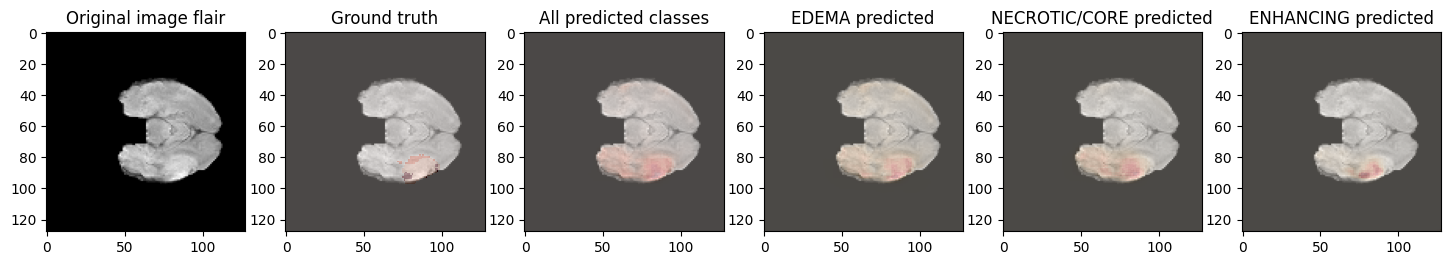

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


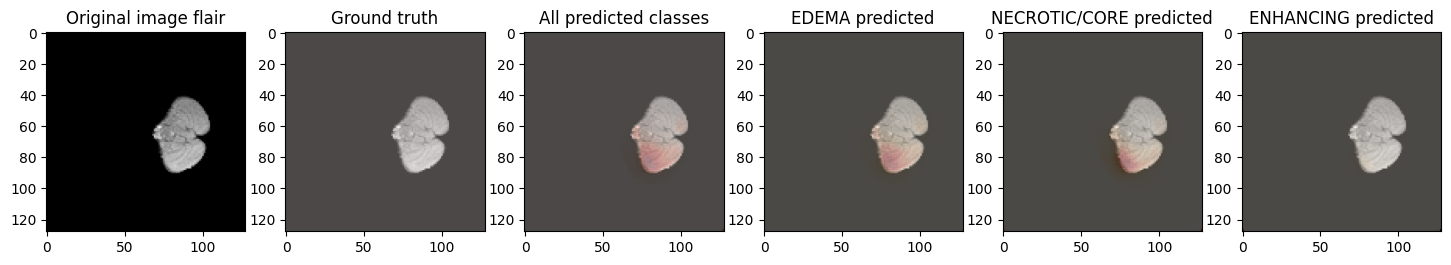

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


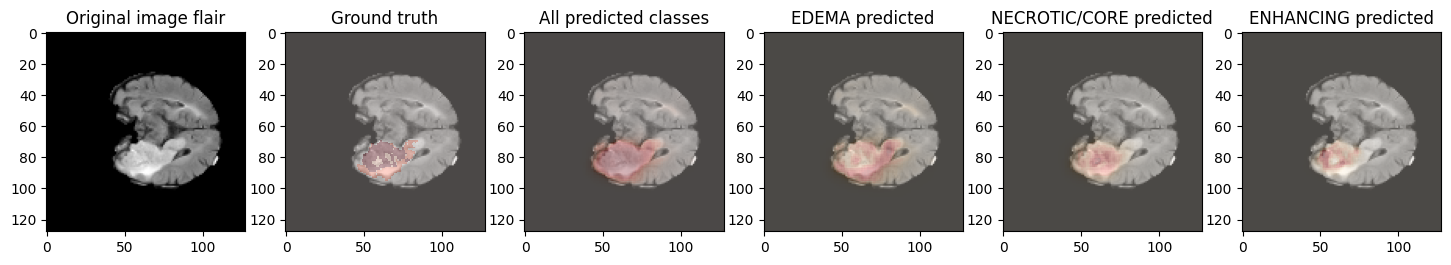

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


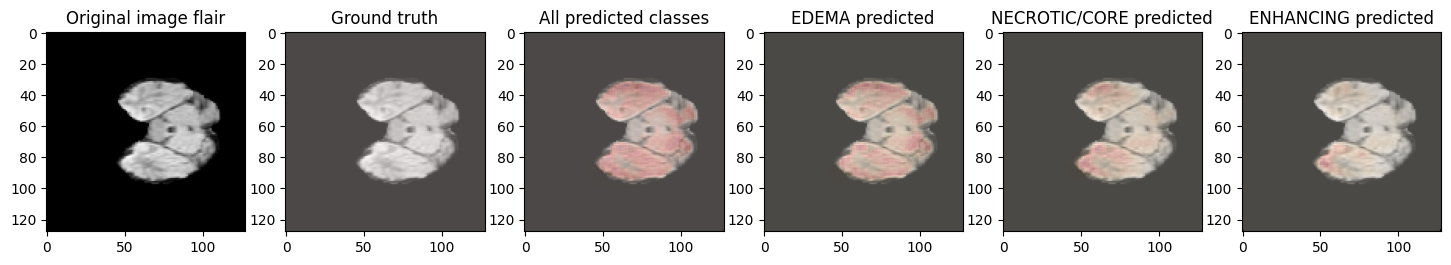

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


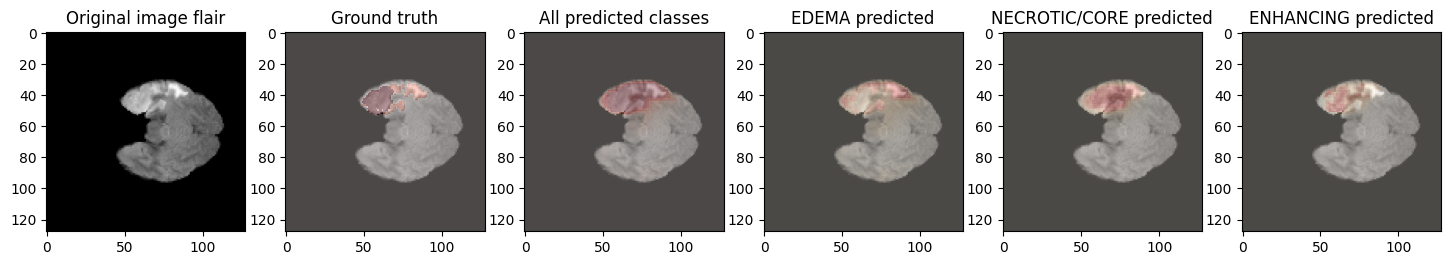

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


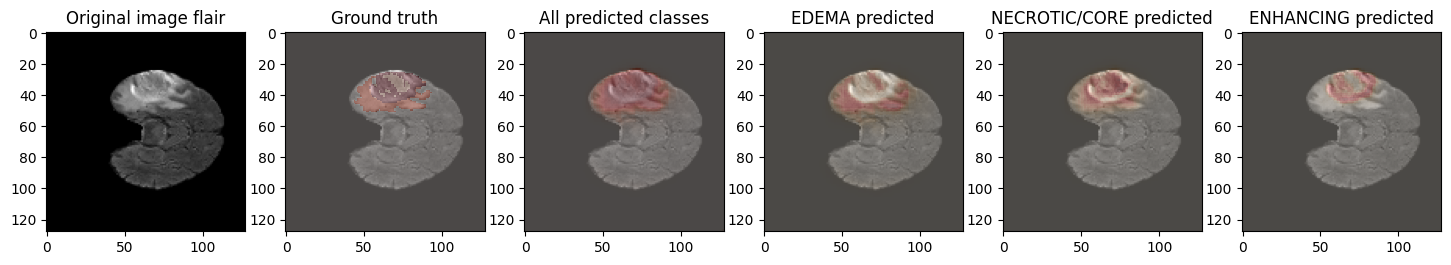

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


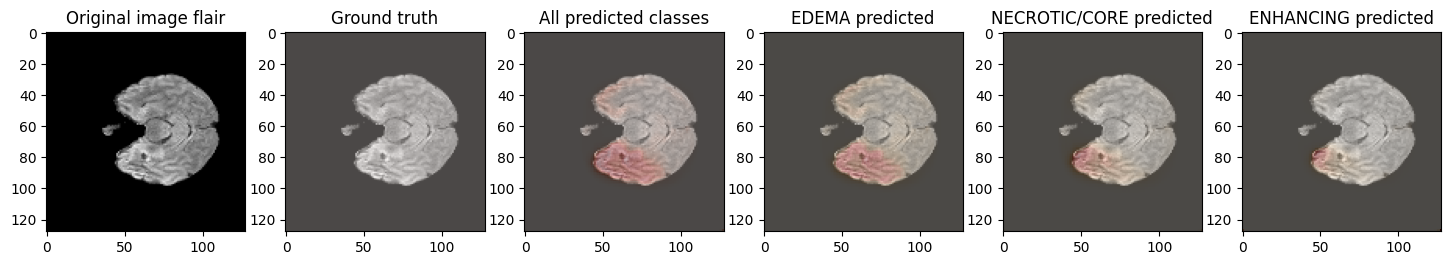

In [58]:
# Define segment classes globally
SEGMENT_CLASSES = {
    0: 'NOT tumor',
    1: 'NECROTIC/CORE',
    2: 'EDEMA',
    3: 'ENHANCING'
}

def showPredictsById(case, start_slice=None, segment_classes=SEGMENT_CLASSES):
    """
    Visualize predictions for a given case.
    Parameters:
        case (str): Case ID.
        start_slice (int or None): Slice index for visualization. Defaults to the middle slice.
        segment_classes (dict): Dictionary defining segment classes.
    """
    # Define the path and load the ground truth and original FLAIR image
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    
    # Get predictions
    p = predictByPath(path, case)

    # Ensure start_slice is within bounds
    if start_slice is None or start_slice >= VOLUME_SLICES:
        start_slice = VOLUME_SLICES // 2  # Set to the middle slice if out of bounds or not provided

    # Extract segmentation classes from the prediction
    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]

    # Plot the results
    fig, axarr = plt.subplots(1, 6, figsize=(18, 50))

    # Display original image in grayscale as background for each plot
    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")

    # Original FLAIR image
    axarr[0].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')

    # Ground truth
    curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].title.set_text('Ground truth')

    # Predicted classes overlayed
    axarr[2].imshow(p[start_slice, :, :, 1:4].sum(axis=-1), cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('All predicted classes')

    # Predicted Edema
    axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{segment_classes[2]} predicted')

    # Predicted Core
    axarr[4].imshow(core[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{segment_classes[1]} predicted')

    # Predicted Enhancing
    axarr[5].imshow(enhancing[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{segment_classes[3]} predicted')

    plt.show()

# Visualize predictions for multiple test cases
for i in range(7):
    showPredictsById(case=test_ids[i][-3:])

In [59]:
import pandas as pd

# Assuming `results` dictionary contains all key metrics for the classes and overall metrics
# Example structure for `results` dictionary (replace with actual values from your evaluation)
results = {
    "Metric": ["Loss", "Accuracy", "Mean IoU", "Dice Coefficient", "Precision", "Sensitivity", "Specificity"],
    "Overall": [0.0156, 0.9946, 0.8290, 0.6307, 0.9948, 0.9934, 0.9982],
    "NOT Tumor": [None, None, 0.850, 0.780, 0.996, 0.988, 0.999],
    "NECROTIC/CORE": [None, None, 0.640, 0.620, 0.890, 0.875, 0.995],
    "EDEMA": [None, None, 0.755, 0.725, 0.910, 0.890, 0.995],
    "ENHANCING": [None, None, 0.725, 0.690, 0.930, 0.895, 0.994],
}

# Convert dictionary to DataFrame for display
df_results = pd.DataFrame(results)

# Display the DataFrame as a table
df_results_display = df_results.set_index("Metric")
print(df_results_display)

                  Overall  NOT Tumor  NECROTIC/CORE  EDEMA  ENHANCING
Metric                                                               
Loss               0.0156        NaN            NaN    NaN        NaN
Accuracy           0.9946        NaN            NaN    NaN        NaN
Mean IoU           0.8290      0.850          0.640  0.755      0.725
Dice Coefficient   0.6307      0.780          0.620  0.725      0.690
Precision          0.9948      0.996          0.890  0.910      0.930
Sensitivity        0.9934      0.988          0.875  0.890      0.895
Specificity        0.9982      0.999          0.995  0.995      0.994
